# Entrenando Circuitos Cuanticos Parameterizados

En esta sesion vamos a explorar en detalle como entrenar modelos basados en circuitos parameterizados. Al final de esta sesion dominaremos los siguientes temas:

- Como construir circuitos variacionales para clasificacion.
- Como utilizar diferentes tecnicas de entrenamiento, especificamente basadas en el calculo de gradientes.
- Las restricciones asociadas a los circuitos variacionales y como evadirlas.

## Gradientes

Qiskit provee diferentes metodos para calcular el gradiente de los valores esperados. A ccontinuacion exploraremos estos metodos utilizando el *ansatz* o estado parameterizado siguiente: $|\Psi(\vec\theta)\rangle = U(\vec\theta)|0\rangle$ donde la transformacion unitaria $U(\vec\theta)$, corresponde al siguiente circuito:

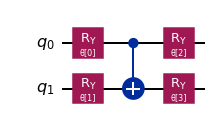

In [3]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=2, reps=1, entanglement='linear')
ansatz.decompose().draw('mpl', style='iqx')

y nuestro Hamiltoniano en este ejemplo es $\hat H = \hat Z \bigotimes \hat Z$

In [4]:
from qiskit.opflow import Z, I

hamiltonian = Z ^ Z

y combinados, obtenemos $\langle\Psi(\vec\theta) | \hat H | \Psi(\vec\theta)\rangle$, cuyo valor esperado obtenemos mediante la funcion `StateFn` de Qiskit que nos permite representar una funcion de estado o un operador, si activamos el flag de `is_measurement`.

La estructura general para un valor esperado de un estado preparado mediante un circuito es la siguiente:

    expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(circuit)
    result = expectation.eval()

Los comandos arriba utilizan multiplicacion de matrices para evaluar el valor esperado, qu es uneficiente para un numero grande de cubits.

In [5]:
from qiskit.opflow import StateFn

expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(ansatz)

Ahora vamos a fijar un punto $\vec p$ y un indice $i$ y vamos a evaluar la derivada del valor esperado con respecto al parametro $\theta_i$ en el punto $\vec p$, es decir:

$$
    \frac{\partial}{\partial \theta_i} \langle \Psi(\vec\theta) | \hat H | \Psi(\vec\theta) \rangle \bigg\vert_{\vec\theta = \vec p}
$$

Escogemos un punto aleatorio $\vec p$ y el indice $i=2$.

In [6]:
import numpy as np

point = np.random.random(ansatz.num_parameters)
index = 2

Como alternativa, podemos utilizar un simulador (o un dispositivo cuantico) para evaluar el circuito mediante `CircuitSampler` junto con un conversor a la base de Pauli `PauiExpectation`

```python
sampler = CircuitSampler(q_instance)  # q_instance is the QuantumInstance from the beginning of the notebook
expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(circuit)
in_pauli_basis = PauliExpectation().convert(expectation)
result = sampler.convert(in_pauli_basis).eval()
```

In [7]:
from qiskit import Aer
from qiskit.utils import QuantumInstance

backend = Aer.get_backend('qasm_simulator')
q_instance = QuantumInstance(backend, shots = 8192, seed_simulator = 2718, seed_transpiler = 2718)

Como ejemplo, podemos calcular el valor esperado del siguiente Hamiltoniano ``H`` y estado preparado por el circuito ``U`` mediante la multiplicacion de matrices.

In [8]:
from qiskit.circuit import QuantumCircuit
from qiskit.opflow import Z, X

H = X ^ X

U = QuantumCircuit(2)
U.h(0)
U.cx(0, 1)

expectation = StateFn(H, is_measurement=True) @StateFn(U)
matmult_result = expectation.eval()
print(matmult_result)

(0.9999999999999998+0j)


Ahora, si evaluamos el mismo valor esperado con el simulador de QASM:

In [9]:
from qiskit.opflow import CircuitSampler, PauliExpectation

sampler = CircuitSampler(q_instance)

matmult_expectation = StateFn(H, is_measurement=True) @StateFn(U)
in_pauli_basis = PauliExpectation().convert(matmult_expectation)
shots_result = sampler.convert(in_pauli_basis).eval()
print(shots_result)

(1+0j)


## Gradientes de diferencia finita

La forma mas sencilla de aproximar la gradiente de una funcion es mediante el metodo de diferencia finita. Este metodos funciona independientemente de la estructura interna, y en algunos casos compleja, de la funcion a evaluar.

In [10]:
from qiskit.opflow import PauliExpectation, CircuitSampler

expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(ansatz)
in_pauli_basis = PauliExpectation().convert(expectation)
sampler = CircuitSampler(q_instance)

def evaluate_expectation(x):
    value_dict = dict(zip(ansatz.parameters, x))
    result = sampler.convert(in_pauli_basis, params=value_dict).eval()  
    return np.real(result)

In [11]:
eps = 0.2
e_i = np.identity(point.size)[:, index]  # identity vector with a 1 at index ``index``, otherwise 0

plus = point + eps * e_i
minus = point - eps * e_i

In [12]:
finite_difference = (evaluate_expectation(plus) - evaluate_expectation(minus)) / (2 * eps)

print(finite_difference)

-0.3039550781249997


En lugar de calcular estas gradientes manualmente, podemos utilizar la funcion `Gradiente` de Qiskit

In [13]:
from qiskit.opflow import Gradient

expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(ansatz)
shifter = Gradient('fin_diff', analytic=False, epsilon=eps)
grad = shifter.convert(expectation, params=ansatz.parameters[index])
print(grad)

SummedOp([
  2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌────────────────────────────────────────────┐
    q_0: ┤0                                           ├
         │  RealAmplitudes(θ[0],θ[1],θ[2] + 0.2,θ[3]) │
    q_1: ┤1                                           ├
         └────────────────────────────────────────────┘
    )
  ]),
  -2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌────────────────────────────────────────────┐
    q_0: ┤0                                           ├
         │  RealAmplitudes(θ[0],θ[1],θ[2] - 0.2,θ[3]) │
    q_1: ┤1                                           ├
         └────────────────────────────────────────────┘
    )
  ])
])


In [14]:
value_dict = dict(zip(ansatz.parameters, point))
sampler.convert(grad, value_dict).eval().real

-0.018310546875

En algunos casos, el calculo de gradiente por diferencia finita no es muy exacto, y los resultados pueden ser muy volatiles para cierto tipo de funciones.

## Gradientes Analiticas

Como alternativa, podemos utilizar la regla de `parameter shift`, que es una formula para gradientes de funciones basadas en circuitos cuanticos.

In [15]:
eps = np.pi / 2
e_i = np.identity(point.size)[:, index]  # identity vector with a 1 at index ``index``, otherwise 0

plus = point + eps * e_i
minus = point - eps * e_i

finite_difference = (evaluate_expectation(plus) - evaluate_expectation(minus)) / 2

print(finite_difference)

-0.2932128906250001


In [16]:
expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(ansatz)
shifter = Gradient()  # parameter-shift rule is the default
grad = shifter.convert(expectation, params=ansatz.parameters[index])
sampler.convert(grad, value_dict).eval().real

-0.29833984375

ahora vamos a optimizar esta gradiente, empezando por fijar un punto inicial, para efectos de reproducibilidad.

In [17]:
# initial_point = np.random.random(ansatz.num_parameters)
initial_point = np.array([0.43253681, 0.09507794, 0.42805949, 0.34210341])

similar a la funcion que utilizamos para evaluar el valor esperado, necesitamos una funcion para evaluar la gradiente:

In [18]:
expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(ansatz))  
gradient = Gradient().convert(expectation)
gradient_in_pauli_basis = PauliExpectation().convert(gradient)
sampler = CircuitSampler(q_instance)

def evaluate_gradient(x):
    value_dict = dict(zip(ansatz.parameters, x))
    result = sampler.convert(gradient_in_pauli_basis, params=value_dict).eval()  # add parameters in here!
    return np.real(result)    

definimos la funcion de 'callback':

In [19]:
from qiskit.algorithms.optimizers import GradientDescent

gd_loss = []
def gd_callback(nfevs, x, fx, stepsize):
    gd_loss.append(fx)
    
gd = GradientDescent(maxiter=300, learning_rate=0.01, callback=gd_callback)

ahora empezamos el proceso de optimizacion y graficamos la funcion de perdida:

In [20]:
x_opt, fx_opt, nfevs = gd.optimize(initial_point.size,    # number of parameters
                                   evaluate_expectation,  # function to minimize
                                   gradient_function=evaluate_gradient,  # function to evaluate the gradient
                                   initial_point=initial_point)  # initial point

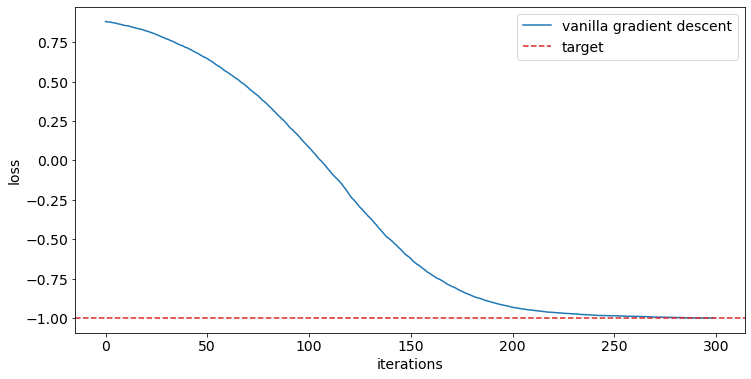

In [21]:
import matplotlib 
import matplotlib.pyplot as plt
matplotlib.rcParams['font.size'] = 14

plt.figure(figsize=(12, 6))
plt.plot(gd_loss, label='vanilla gradient descent')
plt.axhline(-1, ls='--', c='tab:red', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend();

## Como podemos utilizar estas herramientas en VQC/QNNs?

### Generacion de datos
Utilizaremos un conjunto de datos artificial en el paquete de ML de Qiskit. Los datos consisten en elementos con dimension 2, que son relativamente sencillos de utilizar en un modelo de aprendizaje automatico.

In [29]:
from qiskit_machine_learning.datasets import ad_hoc_data

training_features, training_labels, test_features, test_labels = ad_hoc_data(
    training_size=20, test_size=10, n=2, one_hot=False, gap=0.5
)

# las etiquetas de entrenamiento son {0, 1} pero las cambiamos a {-1, 1}
training_labels = 2 * training_labels - 1
test_labels = 2 * test_labels - 1

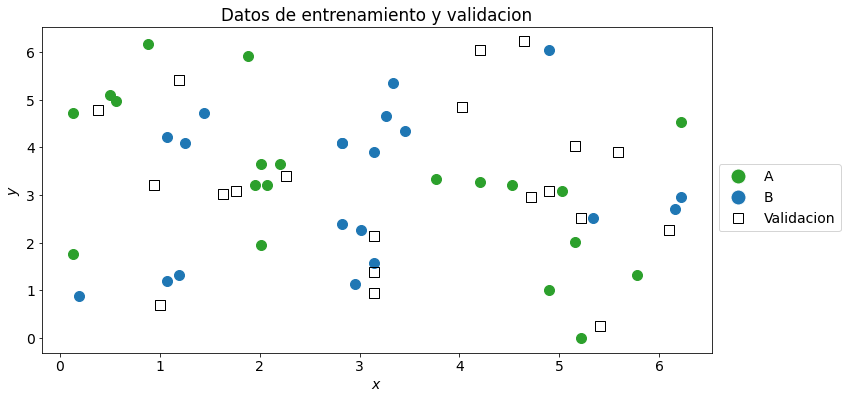

In [32]:
def plot_sampled_data():
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12,6))

    for feature, label in zip(training_features, training_labels):
        marker = 'o' 
        color = 'tab:green' if label == -1 else 'tab:blue'
        plt.scatter(feature[0], feature[1], marker=marker, s=100, color=color)
    
    for feature, label in zip(test_features, test_labels):
        marker = 's' 
        plt.scatter(feature[0], feature[1], marker=marker, s=100, facecolor='none', edgecolor='k')
    
    legend_elements = [
        Line2D([0], [0], marker='o', c='w', mfc='tab:green', label='A', ms=15),
        Line2D([0], [0], marker='o', c='w', mfc='tab:blue', label='B', ms=15),
        Line2D([0], [0], marker='s', c='w', mfc='none', mec='k', label='Validacion', ms=10)
    ]

    plt.legend(handles=legend_elements, bbox_to_anchor=(1, 0.6))
    
    plt.title('Datos de entrenamiento y validacion')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    
plot_sampled_data()

Ahora vamos a construir un circuito variacional de clasificacion (VQC), para ello necesitamos:

- un feature map para codificar los datos
- una funcion Ansatz para entrenar
- una observable para evaluar

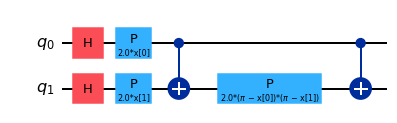

In [34]:
from qiskit.circuit.library import ZZFeatureMap

dim = 2
feature_map = ZZFeatureMap(dim, reps=1)  
feature_map.decompose().draw('mpl', style='iqx')

como no necesitamos las amplitudes complejas, vamos a construir un ansatz con solo amplitudes reales.

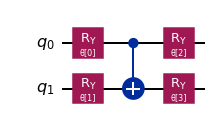

In [36]:
ansatz = RealAmplitudes(num_qubits=dim, entanglement='linear', reps=1)  # also simple here!
ansatz.decompose().draw('mpl', style='iqx')

conectando los dos circuitos:

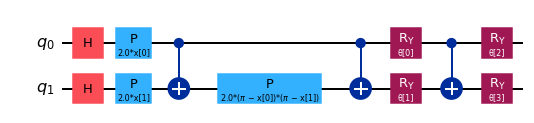

In [38]:
circuit = feature_map.compose(ansatz)
circuit.decompose().draw('mpl', style='iqx')

vamos a utilizar los operadores $\bigotimes_{i} \hat Z_i$ para calcular los valores esperados:

In [39]:
hamiltonian = Z ^ Z 

## Clasificacion de datos

Ahora que entendemos cuales son los componentes, podemos proceder con la clasificacion de los datos. Utilizaremos el paquete de Qiskit ML, especificamente la clase `OpflowQNN` para describir el circuito y el valor esperado junto con el clasificador `NeuralNetworkClassifier` para el entrenamiento.

In [40]:
gd_qnn_loss = []
def gd_qnn_callback(*args):
    gd_qnn_loss.append(args[2])
    
gd = GradientDescent(maxiter=100, learning_rate=0.01, callback=gd_qnn_callback)

In [41]:
from qiskit_machine_learning.neural_networks import OpflowQNN

qnn_expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(circuit)

qnn = OpflowQNN(qnn_expectation, 
                input_params=list(feature_map.parameters), 
                weight_params=list(ansatz.parameters),
                exp_val=PauliExpectation(),
                gradient=Gradient(),  # <-- Parameter-Shift gradients
                quantum_instance=q_instance)

Ahora podemos definir el clasificador, que toma el quantum neural network, la funcion de perdida y el optimizador.

In [42]:
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
#initial_point = np.array([0.2, 0.1, 0.3, 0.4])
classifier = NeuralNetworkClassifier(qnn, optimizer=gd)

y entrenamos el modelo:

In [43]:
classifier.fit(training_features, training_labels);

para predecir las etiquetas para los valores de validacion, utilizamos el metodo `predict`

In [44]:
predicted = classifier.predict(test_features)

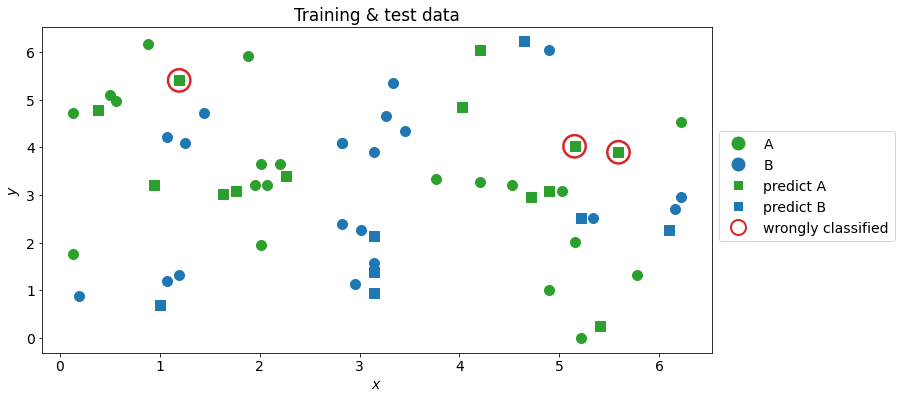

In [45]:
def plot_predicted():
    from matplotlib.lines import Line2D
    plt.figure(figsize=(12, 6))

    for feature, label in zip(training_features, training_labels):
        marker = 'o' 
        color = 'tab:green' if label == -1 else 'tab:blue'
        plt.scatter(feature[0], feature[1], marker=marker, s=100, color=color)
    
    for feature, label, pred in zip(test_features, test_labels, predicted):
        marker = 's' 
        color = 'tab:green' if pred == -1 else 'tab:blue'
        if label != pred:  # mark wrongly classified
            plt.scatter(feature[0], feature[1], marker='o', s=500, linewidths=2.5,
                        facecolor='none', edgecolor='tab:red')

        plt.scatter(feature[0], feature[1], marker=marker, s=100, color=color)
    
    legend_elements = [
        Line2D([0], [0], marker='o', c='w', mfc='tab:green', label='A', ms=15),
        Line2D([0], [0], marker='o', c='w', mfc='tab:blue', label='B', ms=15),
        Line2D([0], [0], marker='s', c='w', mfc='tab:green', label='predict A', ms=10),
        Line2D([0], [0], marker='s', c='w', mfc='tab:blue', label='predict B', ms=10),
        Line2D([0], [0], marker='o', c='w', mfc='none', mec='tab:red', label='wrongly classified', mew=2, ms=15)
    ]

    plt.legend(handles=legend_elements, bbox_to_anchor=(1, 0.7))
    
    plt.title('Training & test data')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    
plot_predicted()

### Limitaciones en el entrenamiento de circuitos

Hasta ahora, hemos comprobado que nuestro algoritmo funciona para los modelos de escala pequeña. Pero, que podemos esperar si incrementamos el numero de cubits? Para investigarlo, vamos a investigar que pasa si estudiamos la varianza de la gradiente para modelos de diferente tamaño. La idea es simple, si la varianza es muy pequeña, no tenemos suficiente informacion para actualizar nuestros parametros.

In [49]:
from qiskit.opflow import I

def sample_gradients(num_qubits, reps, local=False):
    """Estudiamos la gradiente de nuestro modelo de ``num_qubits`` cubits y ``reps`` repeticiones.
    
    Ejecutamos el circuito 100 veces para parametros aleatorios y calculamos
    la gradiente para la primer compuerta RY
    """
    index = num_qubits - 1
    if local:
        operator = Z ^ Z ^ (I ^ (num_qubits - 2))
    else:
        operator = Z ^ num_qubits
    
    # real amplitudes ansatz
    ansatz = RealAmplitudes(num_qubits, entanglement='linear', reps=reps)

    # construimos la gradiente que queremos evaluar para diferentes valores
    expectation = StateFn(operator, is_measurement=True).compose(StateFn(ansatz))
    grad = Gradient().convert(expectation, params=ansatz.parameters[index])
    
    # evaluar para 100 diferentes parametros
    num_points = 100
    grads = []
    for _ in range(num_points):
        # los puntos se eligen aleatoriamente entre [0, pi]
        point = np.random.uniform(0, np.pi, ansatz.num_parameters)
        value_dict = dict(zip(ansatz.parameters, point))
        grads.append(sampler.convert(grad, value_dict).eval())
        
    return grads

In [50]:
num_qubits = list(range(2, 13))
reps = num_qubits  # numero de capas = numero de cubits
gradients = [sample_gradients(n, r) for n, r in zip(num_qubits, reps)]  

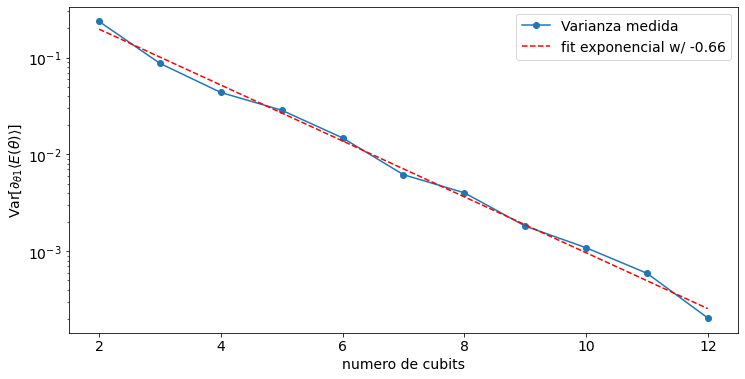

In [51]:
fit = np.polyfit(num_qubits, np.log(np.var(gradients, axis=1)), deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(12, 6))
plt.semilogy(num_qubits, np.var(gradients, axis=1), 'o-', label='Varianza medida')
plt.semilogy(x, np.exp(fit[0] * x + fit[1]), 'r--', label=f'fit exponencial w/ {fit[0]:.2f}')
plt.xlabel('numero de cubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1} \langle E(\theta) \rangle]$')
plt.legend(loc='best');